# Practical assignment on Sparse variational dropout
Author of the assignment: Arsenii Ashukha, author of the tutorial: Nadezhda Chirkova

Paper: Variational Dropout Sparsifies Deep Neural Networks https://arxiv.org/abs/1701.05369


In this task, we will train SparseVD model for a simple fully-connected network on a MNIST dataset. We will start with a short reminder about training neural networks in PyTorch and then implement necessary functions for SparseVD and incorporate them into model training.

## Training fully-connected network in PyTorch

In [1]:
import os
import sys
sys.path.append(f"{os.getcwd()}/../../src")
from logger import Logger

In [2]:
import torch
import numpy as np

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from logger import Logger
from torch.nn import Parameter
from torchvision import datasets, transforms

Load a dataset:

In [3]:
batch_size = 100
# define data preprocessing
tranform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.1307,), (0.3081,))])
# load train and test datasets and wrap them into loaders (batch generators)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=True, download=True,
    transform=tranform), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, download=True,
    transform=tranform), batch_size=batch_size, shuffle=True)

Define a network:

In [4]:
class Net(nn.Module):
    def __init__(self,):
        # components of the model
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300,  10)

    def forward(self, x):
        # how to perform forward pass
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [5]:
def get_free_gpu():
    from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetCount
    nvmlInit()

    return np.argmax([
        nvmlDeviceGetMemoryInfo(nvmlDeviceGetHandleByIndex(i)).free
        for i in range(nvmlDeviceGetCount())
    ])

if torch.cuda.is_available():
    cuda_id = get_free_gpu()
    device = 'cuda:%d' % (get_free_gpu(), )
    print('Selected %s' % (device, ))
else:
    device = 'cpu'
    print('WARNING: using cpu!')

### please, don't remove the following line
x = torch.tensor([1], dtype=torch.float32).to(device)

Selected cuda:2


In [6]:
# make instance of the Net
model = Net().to(device)

Define loss:

In [7]:
lossfun = F.cross_entropy

Define optimizer:

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Create logger instance:

In [9]:
fmt = {'tr_los': '3.1e', 'te_loss': '3.1e'}
logger = Logger('fc_net', fmt=fmt)

Define device and training procedure:

In [26]:
def train(train_loader, test_loader, model, lossfun, logger, device,
          optimizer, scheduler=None, epochs = 100, sparse=False):
    # we will need it for sparsification
    if sparse:
        kl_weight = 0.02

    for epoch in range(1, epochs + 1):
        # we will need it for sparsification
        if sparse:
            kl_weight = min(kl_weight+0.02, 1)
            logger.add_scalar(epoch, 'kl', kl_weight)
            lossfun.kl_weight = kl_weight

        ### iterate over training batches, perform forward and backward pass and count metrics
        model.train()
        train_loss, train_acc = 0, 0 
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()

            output = model(data)
            pred = output.data.max(1)[1]
            loss = lossfun(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss
            train_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

        if scheduler is not None:
            scheduler.step()
            logger.add_scalar(epoch, 'lr', scheduler.get_last_lr()[0])

        logger.add_scalar(epoch, 'tr_los', train_loss / len(train_loader.dataset))
        logger.add_scalar(epoch, 'tr_acc', train_acc / len(train_loader.dataset) * 100)

        ### iterate over testing batches, perform forward pass and count metrics
        model.eval()
        test_loss, test_acc = 0, 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            output = model(data)
            test_loss += float(lossfun(output, target))
            pred = output.data.max(1)[1] 
            test_acc += np.sum(pred.cpu().numpy() == target.data.cpu().numpy())

        logger.add_scalar(epoch, 'te_loss', test_loss / len(test_loader.dataset))
        logger.add_scalar(epoch, 'te_acc', test_acc / len(test_loader.dataset) * 100)

        if sparse:
            for i, c in enumerate(model.children()):
                if hasattr(c, 'kl_reg'):
                    logger.add_scalar(epoch, 'sp_%s' % i, (c.log_alpha.data.cpu().numpy() > model.threshold).mean())

        logger.iter_info()

In [11]:
%%time
train(train_loader, test_loader, model, lossfun, logger, device,
          optimizer, scheduler=None, epochs = 10, sparse=False)

  epoch    tr_los    tr_acc    te_loss    te_acc
-------  --------  --------  ---------  --------
      1   2.4e-03      92.8    1.4e-03      95.9


      2   9.9e-04      97.0    9.0e-04      97.3


      3   6.4e-04      98.0    8.8e-04      97.2


      4   4.9e-04      98.5    8.0e-04      97.5


      5   3.7e-04      98.8    7.7e-04      97.7


      6   2.8e-04      99.1    7.1e-04      97.9


      7   2.2e-04      99.3    7.7e-04      97.8


      8   1.8e-04      99.4    7.2e-04      98.1


      9   1.6e-04      99.5    8.9e-04      97.6


     10   1.3e-04      99.6    8.4e-04      98.0


CPU times: user 2min 23s, sys: 610 ms, total: 2min 24s
Wall time: 2min 23s


## Pytorch cheatsheet

* Main entity in pytorch is a tensor. It can be stored either on cpu or gpu
* Use x.cpu() and x.gpu() to switch between devices
* Type convertation work in the same way, for example x.float()
* Get shape: x.shape, change shape: x.reshape(...)
* To create a new empty tensor on the same device as x and with the same shape use .new: y = x.new(x.shape)
* Matrix multiplication: A.dot(B)
* Element-wise operations: +, -, *, /, torch.sqrt, torch.abs, torch.exp, torch.log, < , >
* Fill tensor x with some values: x.fill\_(5), x.zero\_(), x.ones\_(), x.normal\_()
* Clip tensor x so that values are between A and B: torch.clamp(x, A, B)
* If you want some tensor to be trained, wrap it in nn.Parameter: p = nn.Parameter(x). You can access tensor using p.data

## Sparse Variational Dropout

![image with formulas 1](https://github.com/nadiinchi/BayesianSparsificationTutorial/raw/master/images/slide1rt.png)
![image with formulas 2](https://github.com/nadiinchi/BayesianSparsificationTutorial/raw/master/images/slide2rt.png)



## Implementation of SparseVD

To implement SparseVD, we need to modify two items:
* fully-connected layer
* loss

You need to implement LinearSVDO layer that is inserted into the Net instead of nn.Linear:

In [12]:
class NetSVDO(nn.Module):
    def __init__(self, threshold):
        super(NetSVDO, self).__init__()
        self.fc1 = LinearSVDO(28*28, 300, threshold) ### instead of nn.Linear
        self.fc2 = LinearSVDO(300,  10, threshold) ### instead of nn.Linear
        self.threshold = threshold

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

Implement the layer: initialize parameters (mean values and variances of the weights), perform a forward pass, compute the regularizer (KL-divergence). On the forward pass, sample weights during training, and use mean values of the weights during testing. To sample weights, use reparametrization trick.

In [30]:
class LinearSVDO(nn.Module):
    def __init__(self, in_features, out_features, threshold, bias=True):
        super(LinearSVDO, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.threshold = threshold

        self.mu = Parameter(torch.Tensor(out_features, in_features))
        # Create a Parameter to store log sigma
        self.log_sigma = Parameter(torch.Tensor(out_features, in_features))
        self.bias = Parameter(torch.Tensor(1, out_features))

        self.reset_parameters()

    def reset_parameters(self):
        self.bias.data.zero_()
        self.mu.data.normal_(0, 0.02)
        self.log_sigma.data.fill_(-5)

    def forward(self, x):
        # On the training stage, we sample weights
        # On the testing stage, we zero out weights and perform forward pass with mean weights
        if self.training:
            ########         If training        ##########
            # sample weights from normal distribution using reparametrization trick
            # see slide above for details
            # needed functions and attributes: tensor.new(<shape>), tensor.shape, tensor.normal_(), torch.exp
            epsilon = self.mu.new(self.mu.shape).normal_()
            W = self.mu + epsilon * torch.exp(self.log_sigma)
            return F.linear(x, W) + self.bias

        else:
            ########         If not training        ##########
            # Eval log alpha as a function(log sigma, mu)
            # log alpha = 2 log_sigma - 2 log (|mu|)
            # Needed functions: torch.log, torch.abs
            # Do not forget to add 1e-15 before log for numerical stability
            self.log_alpha = 2*self.log_sigma - 2*torch.log(torch.abs(self.mu)+1e-15)

            # Clip log alpha to be in [-10, 10] for numerical stability 
            self.log_alpha = torch.clamp(self.log_alpha, -10, 10)

            # Prune out redundant wights (weights with log alpha > self.threshold)
            # Needed functions and operations: tensor < tensor, tensor.float()
            W = (self.log_alpha < self.threshold).float() * self.mu

            return F.linear(x, W) + self.bias

    def kl_reg(self):
        ########  Eval Approximation of KL Divergence    ##########
        # Copy your code for computing self.log_alpha:
        self.log_alpha = 2*self.log_sigma - 2*torch.log(torch.abs(self.mu)+1e-15)

        # Clip log alpha to be in [-10, 10] for numerical stability 
        self.log_alpha = torch.clamp(self.log_alpha, -10, 10)

        # Define constants
        k1, k2, k3 = self.mu.data.new_tensor(1).fill_(0.63576), \
                     self.mu.data.new_tensor(1).fill_(1.8732), \
                     self.mu.data.new_tensor(1).fill_(1.48695)

        # Compute KL as a function(log alpha) and sum KL over all weights
        # KL = - k1 * sigmoid(k2 + k3 * log alpha) + 0.5 log1p(exp(-log alpha))
        # We alreade computed self.log_alpha in forward method
        # Needed functions and operations: torch.log1p, torch.sigmoid, torch.exp
        KL = (- k1 * torch.sigmoid(k2 + k3 * self.log_alpha) + 0.5 * torch.log1p(torch.exp(-self.log_alpha))).sum()
        return KL

In [31]:
# make an instance of the Net
model = NetSVDO(threshold=3).to(device)

Implement ELBO (loss):

In [32]:
# Define a new Loss Function -- ELBO
class ELBOLoss(nn.Module):
    def __init__(self, net, train_size):
        super(ELBOLoss, self).__init__()
        self.train_size = train_size
        self.net = net
        self.kl_weight = 1.0

    def forward(self, input, target):
        assert not target.requires_grad
        kl = 0
        for module in self.net.children():
            if hasattr(module, 'kl_reg'):
                kl = kl + module.kl_reg()
        # Estimate ELBO
        ELBO = self.train_size*F.cross_entropy(input, target)  \
                                            + self.kl_weight * kl
        return ELBO

In [33]:
elboloss = ELBOLoss(model, len(train_loader.dataset)).to(device)

## Training SparseVD model

Define optimizer for a new model and create a new logger:

In [34]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,60,70,80], gamma=0.2)
fmt = {'tr_los': '3.1e', 'te_loss': '3.1e', 'sp_0': '.3f', 'sp_1': '.3f', 'lr': '3.1e', 'kl': '.2f'}
logger = Logger('sparse_vd', fmt=fmt)

Train SparseVD model:

In [36]:
train(train_loader, test_loader, model, elboloss, logger, device,
    optimizer, scheduler=scheduler, epochs=100, sparse=True)

      1  0.04  1.0e-03  -1.1e+01      98.4   -2.6e+00      98.1   0.523   0.146


      2  0.06  1.0e-03  -3.8e+01      98.7   -2.3e+01      98.1   0.577   0.178


      3  0.08  1.0e-03  -6.6e+01      98.9   -4.3e+01      98.0   0.634   0.238


      4  0.10  1.0e-03  -9.3e+01      99.0   -7.1e+01      98.2   0.635   0.242


      5  0.12  1.0e-03  -1.2e+02      99.0   -1.0e+02      98.3   0.675   0.275


      6  0.14  1.0e-03  -1.5e+02      99.0   -1.2e+02      98.2   0.708   0.290


      7  0.16  1.0e-03  -1.7e+02      99.1   -1.5e+02      98.1   0.755   0.340


      8  0.18  1.0e-03  -2.0e+02      99.1   -1.8e+02      98.2   0.740   0.365


      9  0.20  1.0e-03  -2.3e+02      99.2   -2.1e+02      98.4   0.777   0.388


     10  0.22  1.0e-03  -2.6e+02      99.2   -2.4e+02      98.3   0.778   0.405


     11  0.24  1.0e-03  -2.9e+02      99.2   -2.6e+02      98.3   0.811   0.433


     12  0.26  1.0e-03  -3.1e+02      99.2   -2.9e+02      98.3   0.772   0.395


     13  0.28  1.0e-03  -3.4e+02      99.2   -3.2e+02      98.3   0.801   0.427


     14  0.30  1.0e-03  -3.7e+02      99.2   -3.5e+02      98.2   0.788   0.410


     15  0.32  1.0e-03  -4.0e+02      99.2   -3.8e+02      98.2   0.840   0.451


     16  0.34  1.0e-03  -4.3e+02      99.2   -4.1e+02      98.3   0.825   0.469


     17  0.36  1.0e-03  -4.6e+02      99.2   -4.4e+02      98.2   0.836   0.474


     18  0.38  1.0e-03  -4.9e+02      99.2   -4.6e+02      98.0   0.849   0.498


     19  0.40  1.0e-03  -5.2e+02      99.2   -4.9e+02      98.1   0.808   0.435


     20  0.42  1.0e-03  -5.5e+02      99.1   -5.3e+02      98.2   0.852   0.506


     21  0.44  1.0e-03  -5.8e+02      99.1   -5.5e+02      98.0   0.825   0.478


     22  0.46  1.0e-03  -6.1e+02      99.2   -5.8e+02      98.2   0.839   0.512


     23  0.48  1.0e-03  -6.4e+02      99.2   -6.2e+02      98.2   0.890   0.556


     24  0.50  1.0e-03  -6.7e+02      99.1   -6.4e+02      98.0   0.834   0.447


     25  0.52  1.0e-03  -7.0e+02      99.1   -6.7e+02      98.1   0.869   0.491


     26  0.54  1.0e-03  -7.3e+02      99.1   -7.0e+02      98.3   0.842   0.496


     27  0.56  1.0e-03  -7.6e+02      99.0   -7.4e+02      98.4   0.853   0.503


     28  0.58  1.0e-03  -7.9e+02      99.1   -7.7e+02      98.2   0.914   0.576


     29  0.60  1.0e-03  -8.2e+02      99.0   -7.9e+02      98.0   0.873   0.513


     30  0.62  1.0e-03  -8.5e+02      99.0   -8.3e+02      98.3   0.884   0.530


     31  0.64  1.0e-03  -8.8e+02      99.0   -8.5e+02      98.2   0.884   0.541


     32  0.66  1.0e-03  -9.1e+02      99.0   -8.9e+02      98.3   0.893   0.561


     33  0.68  1.0e-03  -9.3e+02      98.9   -9.1e+02      98.3   0.863   0.517


     34  0.70  1.0e-03  -9.7e+02      99.0   -9.5e+02      98.2   0.903   0.571


     35  0.72  1.0e-03  -9.9e+02      98.8   -9.7e+02      98.2   0.875   0.533


     36  0.74  1.0e-03  -1.0e+03      98.8   -1.0e+03      98.1   0.890   0.526


     37  0.76  1.0e-03  -1.1e+03      98.9   -1.0e+03      98.2   0.880   0.532


     38  0.78  1.0e-03  -1.1e+03      98.8   -1.1e+03      98.2   0.902   0.562


     39  0.80  1.0e-03  -1.1e+03      98.9   -1.1e+03      98.1   0.883   0.557


     40  0.82  2.0e-04  -1.1e+03      98.7   -1.1e+03      98.3   0.906   0.562


     41  0.84  2.0e-04  -1.2e+03      99.2   -1.2e+03      98.4   0.978   0.734


     42  0.86  2.0e-04  -1.2e+03      99.2   -1.2e+03      98.4   0.979   0.733


     43  0.88  2.0e-04  -1.3e+03      99.2   -1.2e+03      98.5   0.978   0.735


     44  0.90  2.0e-04  -1.3e+03      99.2   -1.3e+03      98.4   0.979   0.727


     45  0.92  2.0e-04  -1.3e+03      99.2   -1.3e+03      98.4   0.979   0.738


     46  0.94  2.0e-04  -1.3e+03      99.1   -1.3e+03      98.4   0.979   0.737


     47  0.96  2.0e-04  -1.4e+03      99.2   -1.4e+03      98.4   0.979   0.747


     48  0.98  2.0e-04  -1.4e+03      99.1   -1.4e+03      98.4   0.979   0.746


     49     1  2.0e-04  -1.4e+03      99.1   -1.4e+03      98.5   0.979   0.739


     50     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.980   0.744


     51     1  4.0e-05  -1.4e+03      99.3   -1.4e+03      98.4   0.984   0.766


     52     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.768


     53     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.769


     54     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.768


     55     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.770


     56     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.771


     57     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.771


     58     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.771


     59     1  4.0e-05  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.770


     60     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.770


     61     1  8.0e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.984   0.771


     62     1  8.0e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.984   0.771


     63     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.772


     64     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.771


     65     1  8.0e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.984   0.771


     66     1  8.0e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.984   0.772


     67     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.772


     68     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.772


     69     1  8.0e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.984   0.772


     70     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     71     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     72     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     73     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     74     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     75     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     76     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     77     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     78     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     79     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     80     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     81     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     82     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     83     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     84     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     85     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     86     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     87     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     88     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     89     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     90     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     91     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     92     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     93     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     94     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     95     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


     96     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     97     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     98     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


     99     1  1.6e-06  -1.4e+03      99.3   -1.4e+03      98.4   0.985   0.773


    100     1  1.6e-06  -1.4e+03      99.2   -1.4e+03      98.4   0.985   0.773


Compute compression rate:

In [37]:
all_w, kep_w = 0, 0

for c in model.children():
    kep_w += (c.log_alpha.data.cpu().numpy() < model.threshold).sum()
    all_w += c.log_alpha.data.cpu().numpy().size

print('kept weight ratio =', all_w/kep_w)

kept weight ratio = 55.27964724994198


    # Good result should be like 
    #   epoch    kl       lr    tr_los    tr_acc    te_loss    te_acc    sp_0    sp_1
    #  -------  ----  -------  --------  --------  ---------  --------  ------  ------
    #       XX     1  1.6e-06  -1.4e+03      99.0   -1.4e+03      98.2   0.817   0.792
    # kept weight ratio = 5.46204998853474

## Visualization

Visualize part of the sparsified weight matrix:

Text(0.5, 1.0, 'Part of the weight matrix of the 1st layer')

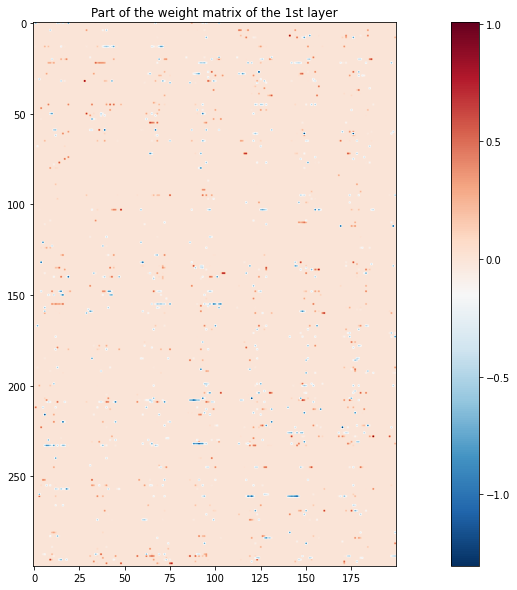

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

# mask zero weights
log_alpha = (model.fc1.log_alpha.detach().cpu().numpy() < 3).astype(np.float)
W = model.fc1.mu.detach().cpu().numpy()

# visualize part of the matrix
plt.figure(figsize=(20, 10))
plt.imshow((log_alpha * W)[:, 200:400], cmap='RdBu_r', interpolation=None)
plt.colorbar()
plt.title("Part of the weight matrix of the 1st layer")

Visualize sparsified weights reshaped to the image shape:

Text(0.5, 1.0, 'Weights reshaped to the image shape')

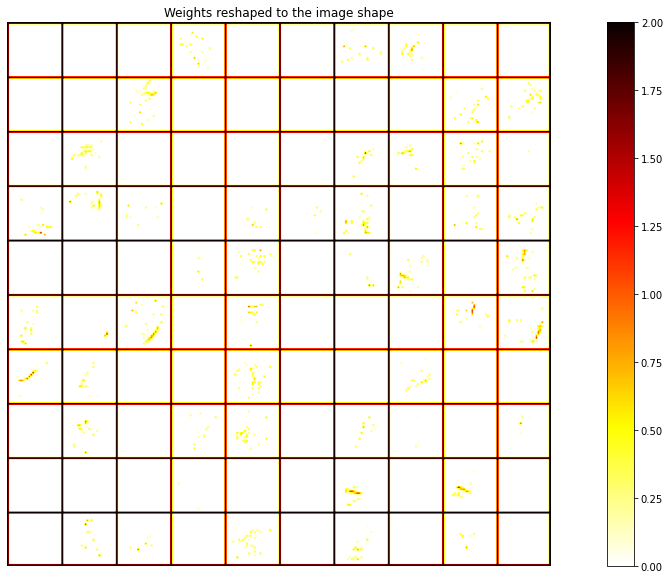

In [39]:
s = 0

z = np.zeros((28*10, 28*10))

for i in range(10):
    for j in range(10):
        s += 1
        z[i*28:(i+1)*28, j*28:(j+1)*28] =  np.abs((log_alpha * W)[s].reshape(28, 28))

z[::28] = 2
z[:, ::28] = 2
z[-1] = 2
z[:, -1] = 2

plt.figure(figsize=(20, 10))
plt.imshow(z, cmap='hot_r')
plt.colorbar()
plt.axis('off')
plt.title("Weights reshaped to the image shape")

Visualize $\log |\mu|$ and $\log \sigma$ of the weights:

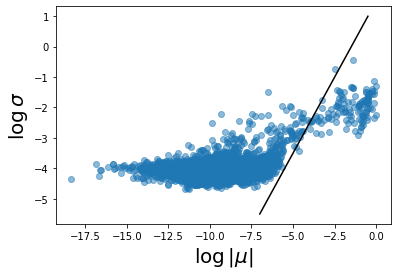

In [40]:
plt.scatter(np.log(np.abs(model.fc1.mu.data.cpu().numpy()))[100:200, 100:200].ravel(),\
            model.fc1.log_sigma.data.cpu().numpy()[100:200, 100:200].ravel(),\
           alpha=0.5)
plt.xlabel("$\log \,|\mu|$", fontsize=20)
plt.ylabel("$\log \,\sigma$", fontsize=20)

ms = np.linspace(-7, -0.5, 100)
plt.plot(ms, ms+1.5, color="black")

## Compression with Sparse Matrixes

Let's check how efficient is weight compression using sparse matrix formats:

In [41]:
import scipy
import numpy as np
from scipy.sparse import csc_matrix, csc_matrix, coo_matrix, dok_matrix

row, col, data = [], [], []
M = list(model.children())[0].mu.data.cpu().numpy()
LA = list(model.children())[0].log_alpha.data.cpu().numpy()

for i in range(300):
    for j in range(28*28):
        if LA[i, j] < 3:
            row += [i]
            col += [j]
            data += [M[i, j]]

Mcsr = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcsc = csc_matrix((data, (row, col)), shape=(300, 28*28))
Mcoo = coo_matrix((data, (row, col)), shape=(300, 28*28))

In [42]:
np.savez_compressed('M_w', M)
scipy.sparse.save_npz('Mcsr_w', Mcsr)
scipy.sparse.save_npz('Mcsc_w', Mcsc)
scipy.sparse.save_npz('Mcoo_w', Mcoo)

In [43]:
ls -lah | grep npz

-rw-r--r-- 1 user user 858K Jul 22 14:14 M_w.npz
-rw-r--r-- 1 user user  20K Jul 22 14:14 Mcoo_w.npz
-rw-r--r-- 1 user user  20K Jul 22 14:14 Mcsc_w.npz
-rw-r--r-- 1 user user  20K Jul 22 14:14 Mcsr_w.npz
